# Análise da Semelhança entre os parágrafos

Este arquivo busca calcular a matriz de semelhança entre os parágrafos utilizando a distância cosseno como métrica e o bag-of-words como modelo de representação do conhecimento.

Sejam u e v sentenças representadas como vetores linha bag-of-words sob o mesmo vocabulário. O ângulo entre esses dois vetores é uma medida de similaridade entre as duas sentenças. O cosseno do ângulo entre os dois vetores pode ser calculado facilmente:

$$
cos \theta = \frac{\sum u_i v_i}{|u||v|} \\
cos \theta = \frac{u}{|u|}*\frac{v^T}{|v|} \\
$$

Se criarmos uma matriz $D_{NxM}$ onde N é o numero de sentenças existentes e M é o tamanho do vocabulário existente da seguinte forma:
$$ D =
\begin{bmatrix}
    \frac{\mathbf{u_1}}{|u_1|} \\
    \frac{\mathbf{u_2}}{|u_2|} \\
    \vdots \\
    \frac{\mathbf{u_N}}{|u_N|} \\
\end{bmatrix}
$$

Portanto, o calculo de todas as semelhanças pode ser realizado através da seguinte expressão:
$
    \cos \theta = D*D^T
$

# Obtenção dos dados a partir do banco de dados

In [1]:
from database_utils import DatabaseConnector, build_dataframe

db_connector = DatabaseConnector('localhost', 'root', '12345', 'CORPUS_VIES')
retrieved_data = db_connector.getDataTextAndLabel()

N_paragraphs = retrieved_data.shape[0]

# Montagem da matriz bag-of-words dos dados

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
v = cv.fit_transform(retrieved_data['texts'])
bag_of_words_matrix = v.toarray()
N_features = bag_of_words_matrix.shape[1]

print(N_features)

6232


In [3]:
import numpy as np
import numpy.matlib

x1 = np.arange(9.0).reshape((3, 3))
x2 = np.array(np.arange(3.0))
x2 = np.matlib.repmat(x2, 3, 1).transpose()


M = np.multiply(x1, 2)

print(x1)

print(x2)
print(M)

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]]
[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]]
[[  0.   2.   4.]
 [  6.   8.  10.]
 [ 12.  14.  16.]]


# Pré tratamento dos dados
Remoção da média e forçando o desvio padrão unitário

In [5]:
# Teste inicial
import numpy as np

v = np.array([[-1, 4], [-6, 10]])
m = v.mean(axis=1).reshape(2,1)
s = v.std(axis = 1).reshape(2,1)

v2 = (v - m)/s

print(v2)
print(m)
print(s)

print(v2.std(axis = 1))

[[-1.  1.]
 [-1.  1.]]
[[ 1.5]
 [ 2. ]]
[[ 2.5]
 [ 8. ]]
[ 1.  1.]


In [4]:
import numpy as np

mean_vector = bag_of_words_matrix.mean(axis=1).reshape(N_paragraphs, 1)
std_vector = bag_of_words_matrix.std(axis=1).reshape(N_paragraphs, 1)

bag_of_words_matrix = (bag_of_words_matrix - mean_vector)/std_vector

bag_of_words_matrix.max()

78.936683487463554

# Cálculo da matriz de correlação

<IPython.core.display.Javascript object>


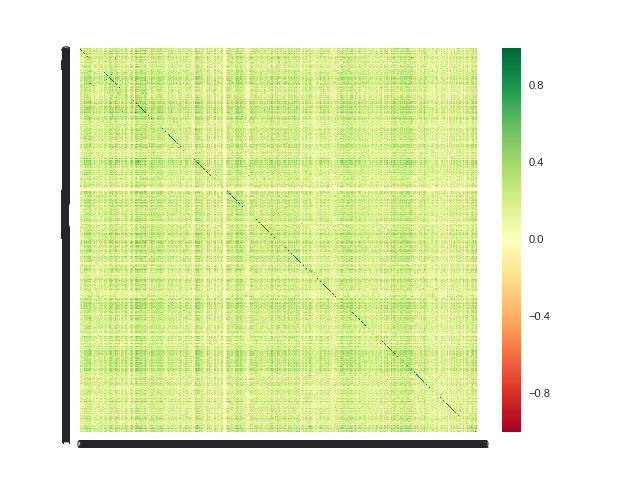

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
C = np.multiply(np.corrcoef(bag_of_words_matrix), 255)
C = np.corrcoef(bag_of_words_matrix)
# print(C.min())
# plt.imshow(C, cmap= 'Greys_r')
# plt.show()
sns.heatmap(np.corrcoef(bag_of_words_matrix), cmap='RdYlGn')

## Correlação entre os dados da classe positiva

In [10]:
def get_correlation_matrix(sentiment, fignum, stemming = False, remove_sw = False):
    from pandas import DataFrame
    from sklearn.feature_extraction.text import CountVectorizer
    from machine_learning_utils import Stemmer
    from nltk.corpus import stopwords
    
    import numpy as np
    import matplotlib.pyplot as plt

    data = db_connector.getDataBySentiment(sentiment)
    
    if (remove_sw):
        cv = CountVectorizer(stop_words= stopwords.words('portuguese'))
    else:
        cv = CountVectorizer()
#     stemmer = Stemmer()
#     if stemming:
#         stemmer = Stemmer()
#         data = DataFrame(data= {'texts': stemmer.transform(data['texts'])})
    
    bag_of_words = cv.fit_transform(data['texts']).toarray()
    
    print("Tamanho do corpus: ", bag_of_words.shape[0])
    print("Dimensionalidade: ", bag_of_words.shape[1])
    
    corr_matrix = np.corrcoef(bag_of_words)
    plt.figure()
#     plt.imshow(np.multiply(corr_matrix, 255), cmap='Greys_r')
#     plt.show()
    sns.heatmap(corr_matrix, cmap='RdYlGn')
    
    return corr_matrix



Tamanho do corpus:  310
Dimensionalidade:  3184


<IPython.core.display.Javascript object>


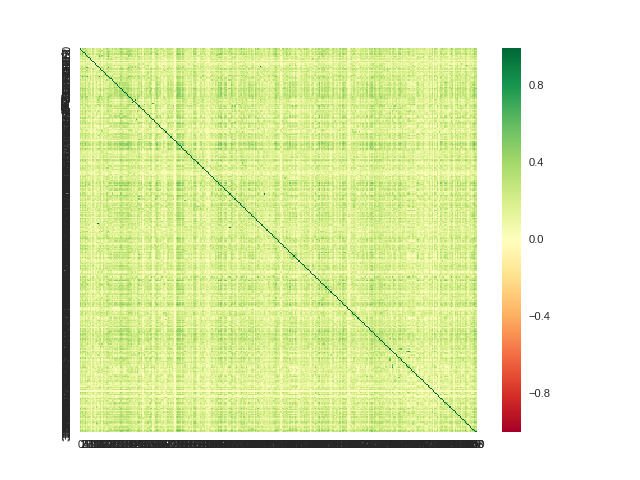

Tamanho do corpus:  391
Dimensionalidade:  3681


<IPython.core.display.Javascript object>


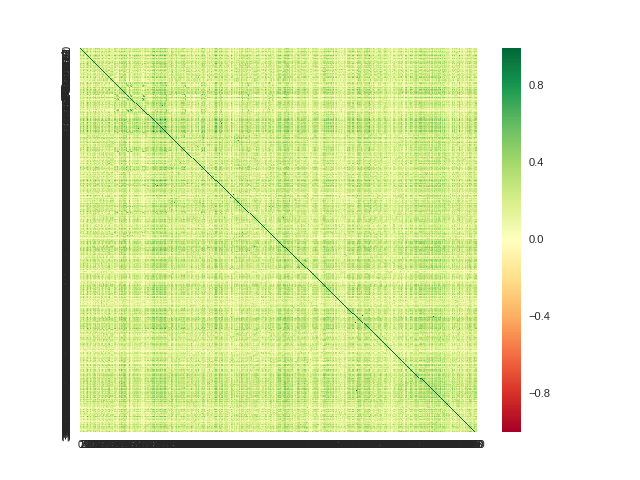

Tamanho do corpus:  341
Dimensionalidade:  2979


<IPython.core.display.Javascript object>


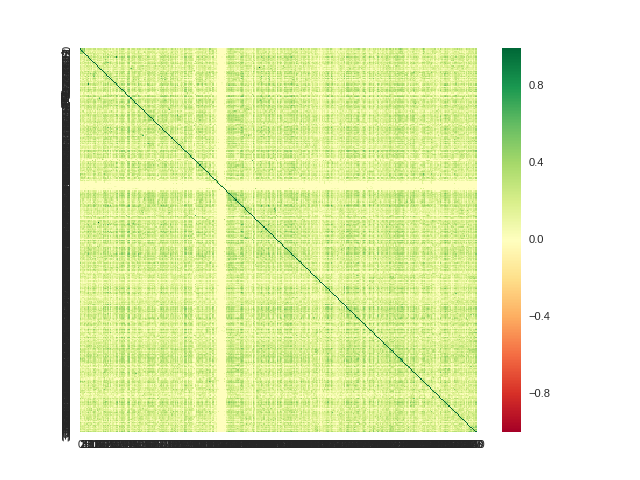

In [11]:
positive_corr = get_correlation_matrix("PO", 1)
negative_corr = get_correlation_matrix("NG", 2)
neutral_corr = get_correlation_matrix("NE", 3)

# Removendo stopwords

SELECT PARAGRAPH, POLARITY FROM PARAGRAPHS WHERE POLARITY = "PO"
310  Paragraphs encountered
Tamanho do corpus:  310
Dimensionalidade:  3053


<IPython.core.display.Javascript object>


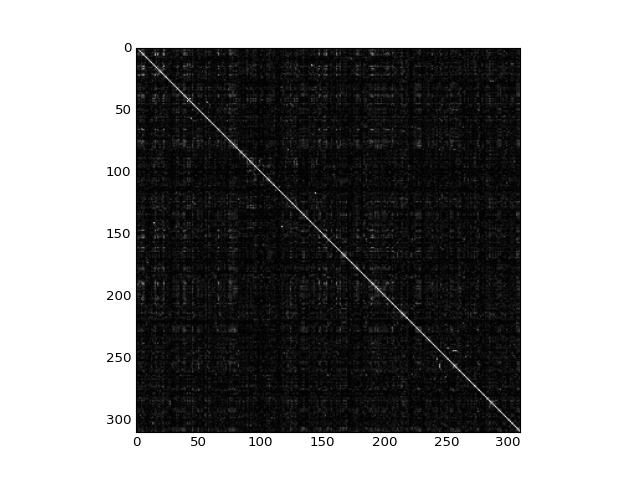

SELECT PARAGRAPH, POLARITY FROM PARAGRAPHS WHERE POLARITY = "NG"
391  Paragraphs encountered
Tamanho do corpus:  391
Dimensionalidade:  3552


<IPython.core.display.Javascript object>


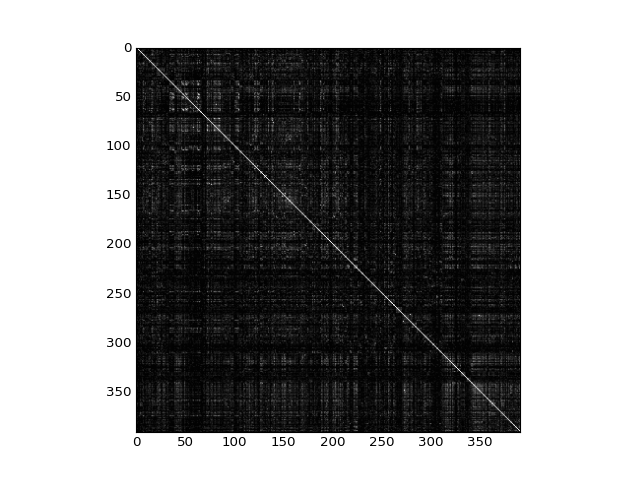

SELECT PARAGRAPH, POLARITY FROM PARAGRAPHS WHERE POLARITY = "NE"
341  Paragraphs encountered
Tamanho do corpus:  341
Dimensionalidade:  2865


<IPython.core.display.Javascript object>


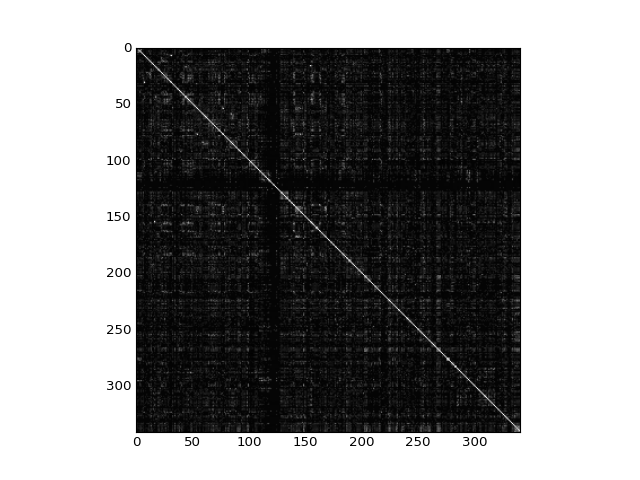

In [12]:
%matplotlib notebook
import nltk
from sklearn.feature_extraction.text import CountVectorizer

PO_sw_corr_matrix = get_correlation_matrix("PO", 1, remove_sw=True)
NG_sw_corr_matrix = get_correlation_matrix("NG", 1, remove_sw=True)
NE_sw_corr_matrix = get_correlation_matrix("NE", 1, remove_sw=True)

# Removendo stopwords e usando stemming

SELECT PARAGRAPH, POLARITY FROM PARAGRAPHS WHERE POLARITY = "PO"
310  Paragraphs encountered
Tamanho do corpus:  310
Dimensionalidade:  1997


<IPython.core.display.Javascript object>


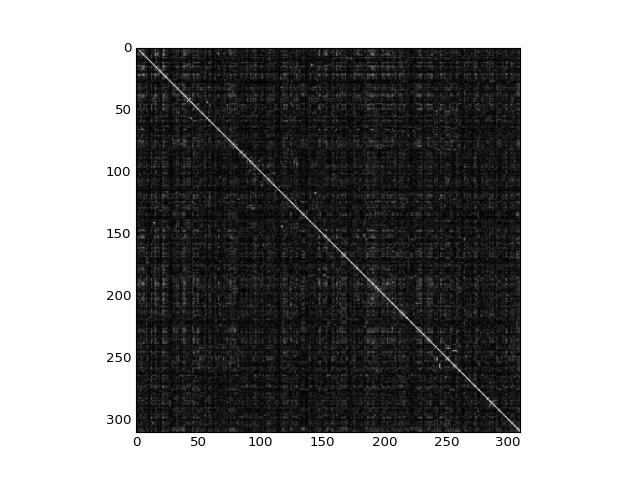

SELECT PARAGRAPH, POLARITY FROM PARAGRAPHS WHERE POLARITY = "NG"
391  Paragraphs encountered
Tamanho do corpus:  391
Dimensionalidade:  2262


<IPython.core.display.Javascript object>


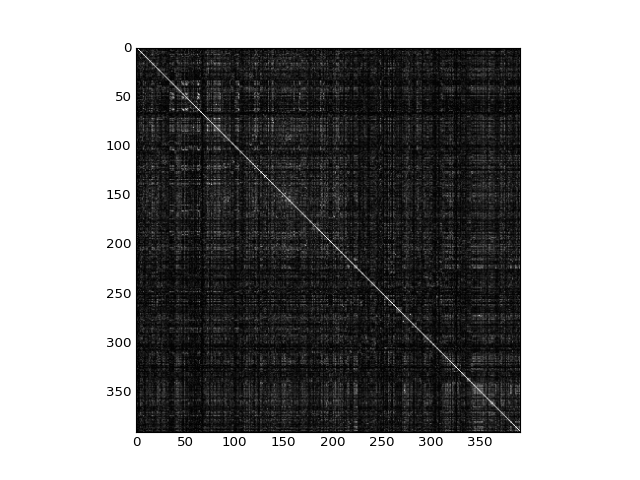

SELECT PARAGRAPH, POLARITY FROM PARAGRAPHS WHERE POLARITY = "NE"
341  Paragraphs encountered
Tamanho do corpus:  341
Dimensionalidade:  1948


<IPython.core.display.Javascript object>


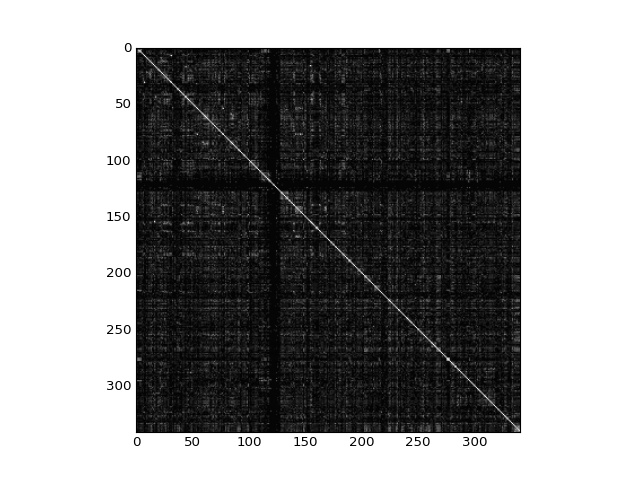

In [13]:
PO_sw_corr_matrix = get_correlation_matrix("PO", 1, remove_sw=True, stemming= True)
NG_sw_corr_matrix = get_correlation_matrix("NG", 1, remove_sw=True, stemming= True)
NE_sw_corr_matrix = get_correlation_matrix("NE", 1, remove_sw=True, stemming= True)

In [21]:
data = db_connector.getDataBySentiment("NE")
len(data)


SELECT PARAGRAPH FROM PARAGRAPHS WHERE POLARITY = "NE"
341  Paragraphs encountered


341